# package use:
numpy
pandas
matplotlib
sklearn
nltk
squarify
autogluon
seaborn
lightgbm
# Enviornment
kernal
Anaconda3 ag Python 3.8.18
Use pip and conda to install packages

# titles

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

## Load dataset from local

In [178]:
titles = pd.read_csv("./titles.csv")
credit = pd.read_csv("./credits.csv")
titles

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,"This collection includes 12 World War II-era propaganda films — many of which are graphic and offensive — discussed in the docuseries ""Five Came Back.""",1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works as a night-time taxi driver in New York City where the perceived decadence and sleaze feed his urge for violent action.,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,"Intent on seeing the Cahulawassee River before it's turned into one huge lake, outdoor fanatic Lewis Medlock takes his friends on a river-rafting trip they'll never forget into the dangerous American back-country.",1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recruits his Knights of the Round Table, including Sir Bedevere the Wise, Sir Lancelot the Brave, Sir Robin the Not-Quite-So-Brave-As-Sir-Lancelot and Sir Galahad the Pure. On the way, Arthur battles the Black Knight who, despite having had all his limbs chopped off, insists he can still fight. They reach Camelot, but Arthur decides not to enter, as ""it is a silly place"".",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,"12 American military prisoners in World War II are ordered to infiltrate a well-guarded enemy château and kill the Nazi officers vacationing there. The soldiers, most of whom are facing death sentences for a variety of violent crimes, agree to the mission and the possible commuting of their sentences.",1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5845,tm1014599,Fine Wine,MOVIE,A beautiful love story that can happen between two people regardless of their age gaps.,2021,NaN,100,"['romance', 'drama']",['NG'],NaN,tt13857480,6.8,45.0,1.466,NaN
5846,tm898842,C/O Kaadhal,MOVIE,A heart warming film that explores the concept of romance with episodes involving four sets of people of different age group.,2021,NaN,134,['drama'],[],NaN,tt11803618,7.7,348.0,NaN,NaN
5847,tm1059008,Lokillo,MOVIE,A controversial TV host and comedian who has built his career on sexist humor is forced to assume a woman's identity to elude a relentless drug dealer.,2021,NaN,90,['comedy'],['CO'],NaN,tt14585902,3.8,68.0,26.005,6.300
5848,tm1035612,Dad Stop Embarrassing Me - The Afterparty,MOVIE,"Jamie Foxx, David Alan Grier and more from the cast of the family comedy discuss the show, humiliating family moments, bad BBQ dishes and sitcom openings.",2021,PG-13,37,[],['US'],NaN,NaN,NaN,NaN,1.296,10.000


In [179]:
titles.dtypes

id                       object
title                    object
type                     object
description              object
release_year              int64
age_certification        object
runtime                   int64
genres                   object
production_countries     object
seasons                 float64
imdb_id                  object
imdb_score              float64
imdb_votes              float64
tmdb_popularity         float64
tmdb_score              float64
dtype: object

# Check Missing value

In [180]:
is_missing = titles.isna().sum()
print(is_missing)

id                         0
title                      1
type                       0
description               18
release_year               0
age_certification       2619
runtime                    0
genres                     0
production_countries       0
seasons                 3744
imdb_id                  403
imdb_score               482
imdb_votes               498
tmdb_popularity           91
tmdb_score               311
dtype: int64


# Data Cleaning
1. Here, there is one missing value in the 'title', which cannot be imputate, so the data without a title is directly deleted.
2. Here, if there are two or more missing values in 'imdb_score', 'imdb_votes', 'tmdb_popularity', 'tmdb_score', the entire data entry is directly deleted to prevent the occurrence of anomalous data during subsequent imputation. A total of 89 entries were removed.

In [181]:
titles_clean = titles.dropna(subset=['title'])
titles_clean = titles_clean.dropna(thresh=2, subset=['imdb_score', 'imdb_votes', 'tmdb_popularity', 'tmdb_score'])
titles_clean.drop(['age_certification', 'seasons', 'imdb_id'], axis=1, inplace=True)
titles_clean


,id,title,type,description,release_year,runtime,genres,production_countries,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works as a night-time taxi driver in New York City where the perceived decadence and sleaze feed his urge for violent action.,1976,114,"['drama', 'crime']",['US'],8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,"Intent on seeing the Cahulawassee River before it's turned into one huge lake, outdoor fanatic Lewis Medlock takes his friends on a river-rafting trip they'll never forget into the dangerous American back-country.",1972,109,"['drama', 'action', 'thriller', 'european']",['US'],7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recruits his Knights of the Round Table, including Sir Bedevere the Wise, Sir Lancelot the Brave, Sir Robin the Not-Quite-So-Brave-As-Sir-Lancelot and Sir Galahad the Pure. On the way, Arthur battles the Black Knight who, despite having had all his limbs chopped off, insists he can still fight. They reach Camelot, but Arthur decides not to enter, as ""it is a silly place"".",1975,91,"['fantasy', 'action', 'comedy']",['GB'],8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,"12 American military prisoners in World War II are ordered to infiltrate a well-guarded enemy château and kill the Nazi officers vacationing there. The soldiers, most of whom are facing death sentences for a variety of violent crimes, agree to the mission and the possible commuting of their sentences.",1967,150,"['war', 'action']","['GB', 'US']",7.7,72662.0,20.398,7.600
5,ts22164,Monty Python's Flying Circus,SHOW,"A British sketch comedy series with the shows being composed of surreality, risqué or innuendo-laden humour, sight gags and observational sketches without punchlines.",1969,30,"['comedy', 'european']",['GB'],8.8,73424.0,17.617,8.306
...,...,...,...,...,...,...,...,...,...,...,...,...
5845,tm1014599,Fine Wine,MOVIE,A beautiful love story that can happen between two people regardless of their age gaps.,2021,100,"['romance', 'drama']",['NG'],6.8,45.0,1.466,NaN
5846,tm898842,C/O Kaadhal,MOVIE,A heart warming film that explores the concept of romance with episodes involving four sets of people of different age group.,2021,134,['drama'],[],7.7,348.0,NaN,NaN
5847,tm1059008,Lokillo,MOVIE,A controversial TV host and comedian who has built his career on sexist humor is forced to assume a woman's identity to elude a relentless drug dealer.,2021,90,['comedy'],['CO'],3.8,68.0,26.005,6.300
5848,tm1035612,Dad Stop Embarrassing Me - The Afterparty,MOVIE,"Jamie Foxx, David Alan Grier and more from the cast of the family comedy discuss the show, humiliating family moments, bad BBQ dishes and sitcom openings.",2021,37,[],['US'],NaN,NaN,1.296,10.000


# Data imputation
The KNNImputer algorithm is chosen for filling missing values instead of using mean, median, etc., due to its non-parametric approach based on similarity, making it suitable for multi-feature imputation, thereby enhancing data processing flexibility and consistency. Using mean may introduce bias and fail to accurately reflect the true data patterns.

In [182]:
from sklearn.impute import KNNImputer

# create KNNImputer
imputer = KNNImputer(n_neighbors=30)

# the column need to bt imputate
columns_to_impute = ['imdb_score', 'imdb_votes', 'tmdb_popularity', 'tmdb_score']

# change NaN from original table
titles_clean[columns_to_impute] = imputer.fit_transform(titles_clean[columns_to_impute])

titles_clean

,id,title,type,description,release_year,runtime,genres,production_countries,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works as a night-time taxi driver in New York City where the perceived decadence and sleaze feed his urge for violent action.,1976,114,"['drama', 'crime']",['US'],8.200000,808582.000000,40.965000,8.179000
2,tm154986,Deliverance,MOVIE,"Intent on seeing the Cahulawassee River before it's turned into one huge lake, outdoor fanatic Lewis Medlock takes his friends on a river-rafting trip they'll never forget into the dangerous American back-country.",1972,109,"['drama', 'action', 'thriller', 'european']",['US'],7.700000,107673.000000,10.010000,7.300000
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recruits his Knights of the Round Table, including Sir Bedevere the Wise, Sir Lancelot the Brave, Sir Robin the Not-Quite-So-Brave-As-Sir-Lancelot and Sir Galahad the Pure. On the way, Arthur battles the Black Knight who, despite having had all his limbs chopped off, insists he can still fight. They reach Camelot, but Arthur decides not to enter, as ""it is a silly place"".",1975,91,"['fantasy', 'action', 'comedy']",['GB'],8.200000,534486.000000,15.461000,7.811000
4,tm120801,The Dirty Dozen,MOVIE,"12 American military prisoners in World War II are ordered to infiltrate a well-guarded enemy château and kill the Nazi officers vacationing there. The soldiers, most of whom are facing death sentences for a variety of violent crimes, agree to the mission and the possible commuting of their sentences.",1967,150,"['war', 'action']","['GB', 'US']",7.700000,72662.000000,20.398000,7.600000
5,ts22164,Monty Python's Flying Circus,SHOW,"A British sketch comedy series with the shows being composed of surreality, risqué or innuendo-laden humour, sight gags and observational sketches without punchlines.",1969,30,"['comedy', 'european']",['GB'],8.800000,73424.000000,17.617000,8.306000
...,...,...,...,...,...,...,...,...,...,...,...,...
5845,tm1014599,Fine Wine,MOVIE,A beautiful love story that can happen between two people regardless of their age gaps.,2021,100,"['romance', 'drama']",['NG'],6.800000,45.000000,1.466000,6.570000
5846,tm898842,C/O Kaadhal,MOVIE,A heart warming film that explores the concept of romance with episodes involving four sets of people of different age group.,2021,134,['drama'],[],7.700000,348.000000,7.928867,6.841433
5847,tm1059008,Lokillo,MOVIE,A controversial TV host and comedian who has built his career on sexist humor is forced to assume a woman's identity to elude a relentless drug dealer.,2021,90,['comedy'],['CO'],3.800000,68.000000,26.005000,6.300000
5848,tm1035612,Dad Stop Embarrassing Me - The Afterparty,MOVIE,"Jamie Foxx, David Alan Grier and more from the cast of the family comedy discuss the show, humiliating family moments, bad BBQ dishes and sitcom openings.",2021,37,[],['US'],6.433333,15655.066667,1.296000,10.000000


In [183]:
titles_clean.isna().sum()

id                       0
title                    0
type                     0
description             10
release_year             0
runtime                  0
genres                   0
production_countries     0
imdb_score               0
imdb_votes               0
tmdb_popularity          0
tmdb_score               0
dtype: int64

# Normalization
Normalize imdb_score, imdb_votes, tmdb_popularity and tmdb_score by using min-max scalling

In [184]:
# create MinMaxScaler
scaler = MinMaxScaler()

# list columns that need to be normalized
columns_to_normalize = ['imdb_score', 'imdb_votes', 'tmdb_popularity', 'tmdb_score']

# create new column for normalized data
for col in columns_to_normalize:
    new_col_name = col + '_normalized'
    titles_clean[new_col_name] = scaler.fit_transform(titles_clean[[col]])

titles_clean

,id,title,type,description,release_year,runtime,genres,production_countries,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,imdb_score_normalized,imdb_votes_normalized,tmdb_popularity_normalized,tmdb_score_normalized
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works as a night-time taxi driver in New York City where the perceived decadence and sleaze feed his urge for violent action.,1976,114,"['drama', 'crime']",['US'],8.200000,808582.000000,40.965000,8.179000,0.827160,0.352440,0.017990,0.808316
2,tm154986,Deliverance,MOVIE,"Intent on seeing the Cahulawassee River before it's turned into one huge lake, outdoor fanatic Lewis Medlock takes his friends on a river-rafting trip they'll never forget into the dangerous American back-country.",1972,109,"['drama', 'action', 'thriller', 'european']",['US'],7.700000,107673.000000,10.010000,7.300000,0.765432,0.046930,0.004378,0.715789
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recruits his Knights of the Round Table, including Sir Bedevere the Wise, Sir Lancelot the Brave, Sir Robin the Not-Quite-So-Brave-As-Sir-Lancelot and Sir Galahad the Pure. On the way, Arthur battles the Black Knight who, despite having had all his limbs chopped off, insists he can still fight. They reach Camelot, but Arthur decides not to enter, as ""it is a silly place"".",1975,91,"['fantasy', 'action', 'comedy']",['GB'],8.200000,534486.000000,15.461000,7.811000,0.827160,0.232968,0.006775,0.769579
4,tm120801,The Dirty Dozen,MOVIE,"12 American military prisoners in World War II are ordered to infiltrate a well-guarded enemy château and kill the Nazi officers vacationing there. The soldiers, most of whom are facing death sentences for a variety of violent crimes, agree to the mission and the possible commuting of their sentences.",1967,150,"['war', 'action']","['GB', 'US']",7.700000,72662.000000,20.398000,7.600000,0.765432,0.031670,0.008946,0.747368
5,ts22164,Monty Python's Flying Circus,SHOW,"A British sketch comedy series with the shows being composed of surreality, risqué or innuendo-laden humour, sight gags and observational sketches without punchlines.",1969,30,"['comedy', 'european']",['GB'],8.800000,73424.000000,17.617000,8.306000,0.901235,0.032002,0.007723,0.821684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5845,tm1014599,Fine Wine,MOVIE,A beautiful love story that can happen between two people regardless of their age gaps.,2021,100,"['romance', 'drama']",['NG'],6.800000,45.000000,1.466000,6.570000,0.654321,0.000017,0.000620,0.638947
5846,tm898842,C/O Kaadhal,MOVIE,A heart warming film that explores the concept of romance with episodes involving four sets of people of different age group.,2021,134,['drama'],[],7.700000,348.000000,7.928867,6.841433,0.765432,0.000150,0.003463,0.667519
5847,tm1059008,Lokillo,MOVIE,A controversial TV host and comedian who has built his career on sexist humor is forced to assume a woman's identity to elude a relentless drug dealer.,2021,90,['comedy'],['CO'],3.800000,68.000000,26.005000,6.300000,0.283951,0.000027,0.011412,0.610526
5848,tm1035612,Dad Stop Embarrassing Me - The Afterparty,MOVIE,"Jamie Foxx, David Alan Grier and more from the cast of the family comedy discuss the show, humiliating family moments, bad BBQ dishes and sitcom openings.",2021,37,[],['US'],6.433333,15655.066667,1.296000,10.000000,0.609053,0.006822,0.000546,1.000000


Using the standardized data of imdb_score, imdb_votes, tmdb_popularity, and tmdb_score, calculate a value with weights of 0.4, 0.2, 0.1, and 0.3 to create a new column called total_score.

In [185]:
weight_imdb_score = 0.4
weight_imdb_votes = 0.2
weight_tmdb_popularity = 0.1
weight_tmdb_score = 0.3
titles_clean['total_score'] = (titles_clean['imdb_score_normalized'] * weight_imdb_score +
                               titles_clean['imdb_votes_normalized'] * weight_imdb_votes +
                               titles_clean['tmdb_popularity_normalized'] * weight_tmdb_popularity +
                               titles_clean['tmdb_score_normalized'] * weight_tmdb_score)

print(titles_clean[['total_score']])


      total_score
1        0.645646
2        0.530733
3        0.609009
4        0.537612
5        0.614172
...           ...
5845     0.453478
5846     0.506805
5847     0.297885
5848     0.545040
5849     0.611210

[5760 rows x 1 columns]


# Fix Multiple Genres and Production countries

In [186]:
import ast
titles_clean['genres'] = titles_clean['genres'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])
titles_clean['production_countries'] = titles_clean['production_countries'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

In [187]:
genres_list = pd.get_dummies(titles_clean['genres'].explode(), prefix='genre')
genres_list = genres_list.groupby(level=0).sum()

titles_clean = pd.concat([titles_clean, genres_list], axis=1)

titles_clean

,id,title,type,description,release_year,runtime,genres,production_countries,imdb_score,imdb_votes,...,genre_history,genre_horror,genre_music,genre_reality,genre_romance,genre_scifi,genre_sport,genre_thriller,genre_war,genre_western
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works as a night-time taxi driver in New York City where the perceived decadence and sleaze feed his urge for violent action.,1976,114,"[drama, crime]",[US],8.200000,808582.000000,...,0,0,0,0,0,0,0,0,0,0
2,tm154986,Deliverance,MOVIE,"Intent on seeing the Cahulawassee River before it's turned into one huge lake, outdoor fanatic Lewis Medlock takes his friends on a river-rafting trip they'll never forget into the dangerous American back-country.",1972,109,"[drama, action, thriller, european]",[US],7.700000,107673.000000,...,0,0,0,0,0,0,0,1,0,0
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recruits his Knights of the Round Table, including Sir Bedevere the Wise, Sir Lancelot the Brave, Sir Robin the Not-Quite-So-Brave-As-Sir-Lancelot and Sir Galahad the Pure. On the way, Arthur battles the Black Knight who, despite having had all his limbs chopped off, insists he can still fight. They reach Camelot, but Arthur decides not to enter, as ""it is a silly place"".",1975,91,"[fantasy, action, comedy]",[GB],8.200000,534486.000000,...,0,0,0,0,0,0,0,0,0,0
4,tm120801,The Dirty Dozen,MOVIE,"12 American military prisoners in World War II are ordered to infiltrate a well-guarded enemy château and kill the Nazi officers vacationing there. The soldiers, most of whom are facing death sentences for a variety of violent crimes, agree to the mission and the possible commuting of their sentences.",1967,150,"[war, action]","[GB, US]",7.700000,72662.000000,...,0,0,0,0,0,0,0,0,1,0
5,ts22164,Monty Python's Flying Circus,SHOW,"A British sketch comedy series with the shows being composed of surreality, risqué or innuendo-laden humour, sight gags and observational sketches without punchlines.",1969,30,"[comedy, european]",[GB],8.800000,73424.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5845,tm1014599,Fine Wine,MOVIE,A beautiful love story that can happen between two people regardless of their age gaps.,2021,100,"[romance, drama]",[NG],6.800000,45.000000,...,0,0,0,0,1,0,0,0,0,0
5846,tm898842,C/O Kaadhal,MOVIE,A heart warming film that explores the concept of romance with episodes involving four sets of people of different age group.,2021,134,[drama],[],7.700000,348.000000,...,0,0,0,0,0,0,0,0,0,0
5847,tm1059008,Lokillo,MOVIE,A controversial TV host and comedian who has built his career on sexist humor is forced to assume a woman's identity to elude a relentless drug dealer.,2021,90,[comedy],[CO],3.800000,68.000000,...,0,0,0,0,0,0,0,0,0,0
5848,tm1035612,Dad Stop Embarrassing Me - The Afterparty,MOVIE,"Jamie Foxx, David Alan Grier and more from the cast of the family comedy discuss the show, humiliating family moments, bad BBQ dishes and sitcom openings.",2021,37,[],[US],6.433333,15655.066667,...,0,0,0,0,0,0,0,0,0,0


In [188]:
titles_clean.dtypes

id                             object
title                          object
type                           object
description                    object
release_year                    int64
runtime                         int64
genres                         object
production_countries           object
imdb_score                    float64
imdb_votes                    float64
tmdb_popularity               float64
tmdb_score                    float64
imdb_score_normalized         float64
imdb_votes_normalized         float64
tmdb_popularity_normalized    float64
tmdb_score_normalized         float64
total_score                   float64
genre_action                    uint8
genre_animation                 uint8
genre_comedy                    uint8
genre_crime                     uint8
genre_documentation             uint8
genre_drama                     uint8
genre_european                  uint8
genre_family                    uint8
genre_fantasy                   uint8
genre_histor

In [189]:
temp = titles_clean.explode("production_countries")
country_counts = temp["production_countries"].value_counts().to_dict()
country_counts

threshold = 100

# Create a new dictionary to store the updated data.
new_country_counts = {}

other_value = 0

# Count the frequency of countries
for country, value in country_counts.items():
    if value < threshold:
        other_value += value 
    else:
        new_country_counts[country] = value

new_country_counts["Other"] = other_value
new_country_counts


{'US': 2308,
 'IN': 617,
 'GB': 403,
 'JP': 285,
 'FR': 246,
 'KR': 224,
 'CA': 217,
 'ES': 211,
 'DE': 139,
 'MX': 126,
 'BR': 102,
 'CN': 102,
 'Other': 1480}

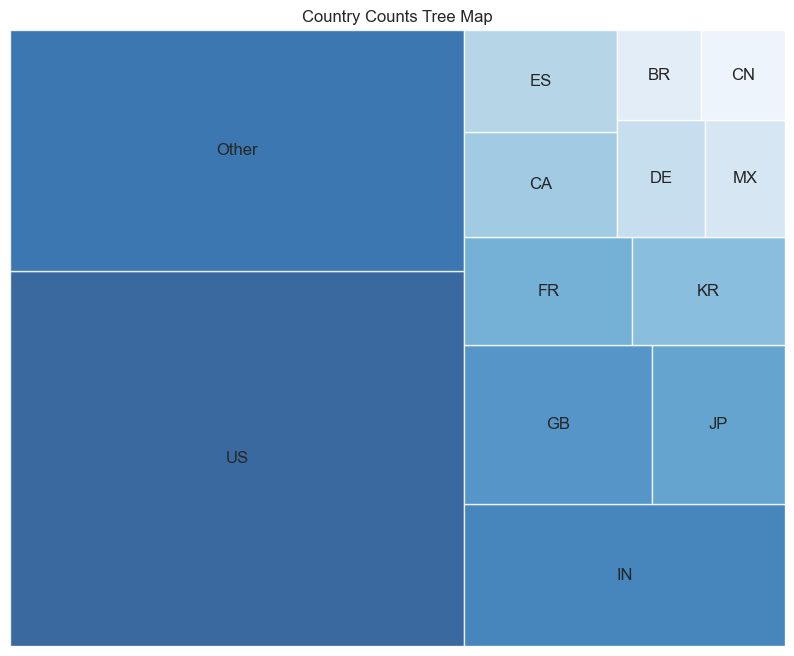

In [190]:
import matplotlib.pyplot as plt
import squarify

df = pd.DataFrame(new_country_counts.items(), columns=['Country', 'Count'])
df = df.sort_values(by='Count', ascending=False)

# create Tree Map
plt.figure(figsize=(10, 8))
squarify.plot(sizes=df['Count'], label=df['Country'], alpha=0.8, color=sns.color_palette('Blues_r', n_colors=len(df)))

plt.title('Country Counts Tree Map')
plt.axis('off')
plt.show()


In [191]:
def fix_countries(countries):
    if len(countries) > 1:
        target_country = max(country_counts, key=country_counts.get)
        return [target_country]
    elif len(countries) == 0:
        return ['Other']
    else:
        return countries


titles_clean['production_countries'] = titles_clean['production_countries'].apply(fix_countries)

country_counts = titles_clean['production_countries'].value_counts()
threshold = 100
set_other = [key for key, value in country_counts.items() if value < threshold]

titles_clean['production_countries'] = titles_clean['production_countries'].apply(lambda x: ['Other'] if x in set_other else x)

titles_clean


,id,title,type,description,release_year,runtime,genres,production_countries,imdb_score,imdb_votes,...,genre_history,genre_horror,genre_music,genre_reality,genre_romance,genre_scifi,genre_sport,genre_thriller,genre_war,genre_western
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works as a night-time taxi driver in New York City where the perceived decadence and sleaze feed his urge for violent action.,1976,114,"[drama, crime]",[US],8.200000,808582.000000,...,0,0,0,0,0,0,0,0,0,0
2,tm154986,Deliverance,MOVIE,"Intent on seeing the Cahulawassee River before it's turned into one huge lake, outdoor fanatic Lewis Medlock takes his friends on a river-rafting trip they'll never forget into the dangerous American back-country.",1972,109,"[drama, action, thriller, european]",[US],7.700000,107673.000000,...,0,0,0,0,0,0,0,1,0,0
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recruits his Knights of the Round Table, including Sir Bedevere the Wise, Sir Lancelot the Brave, Sir Robin the Not-Quite-So-Brave-As-Sir-Lancelot and Sir Galahad the Pure. On the way, Arthur battles the Black Knight who, despite having had all his limbs chopped off, insists he can still fight. They reach Camelot, but Arthur decides not to enter, as ""it is a silly place"".",1975,91,"[fantasy, action, comedy]",[GB],8.200000,534486.000000,...,0,0,0,0,0,0,0,0,0,0
4,tm120801,The Dirty Dozen,MOVIE,"12 American military prisoners in World War II are ordered to infiltrate a well-guarded enemy château and kill the Nazi officers vacationing there. The soldiers, most of whom are facing death sentences for a variety of violent crimes, agree to the mission and the possible commuting of their sentences.",1967,150,"[war, action]",[US],7.700000,72662.000000,...,0,0,0,0,0,0,0,0,1,0
5,ts22164,Monty Python's Flying Circus,SHOW,"A British sketch comedy series with the shows being composed of surreality, risqué or innuendo-laden humour, sight gags and observational sketches without punchlines.",1969,30,"[comedy, european]",[GB],8.800000,73424.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5845,tm1014599,Fine Wine,MOVIE,A beautiful love story that can happen between two people regardless of their age gaps.,2021,100,"[romance, drama]",[Other],6.800000,45.000000,...,0,0,0,0,1,0,0,0,0,0
5846,tm898842,C/O Kaadhal,MOVIE,A heart warming film that explores the concept of romance with episodes involving four sets of people of different age group.,2021,134,[drama],[Other],7.700000,348.000000,...,0,0,0,0,0,0,0,0,0,0
5847,tm1059008,Lokillo,MOVIE,A controversial TV host and comedian who has built his career on sexist humor is forced to assume a woman's identity to elude a relentless drug dealer.,2021,90,[comedy],[Other],3.800000,68.000000,...,0,0,0,0,0,0,0,0,0,0
5848,tm1035612,Dad Stop Embarrassing Me - The Afterparty,MOVIE,"Jamie Foxx, David Alan Grier and more from the cast of the family comedy discuss the show, humiliating family moments, bad BBQ dishes and sitcom openings.",2021,37,[],[US],6.433333,15655.066667,...,0,0,0,0,0,0,0,0,0,0


# Credit

In [192]:
credit.head()

,person_id,id,name,character,role
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR


In [193]:
titles_clean.head()

,id,title,type,description,release_year,runtime,genres,production_countries,imdb_score,imdb_votes,...,genre_history,genre_horror,genre_music,genre_reality,genre_romance,genre_scifi,genre_sport,genre_thriller,genre_war,genre_western
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works as a night-time taxi driver in New York City where the perceived decadence and sleaze feed his urge for violent action.,1976,114,"[drama, crime]",[US],8.2,808582.0,...,0,0,0,0,0,0,0,0,0,0
2,tm154986,Deliverance,MOVIE,"Intent on seeing the Cahulawassee River before it's turned into one huge lake, outdoor fanatic Lewis Medlock takes his friends on a river-rafting trip they'll never forget into the dangerous American back-country.",1972,109,"[drama, action, thriller, european]",[US],7.7,107673.0,...,0,0,0,0,0,0,0,1,0,0
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recruits his Knights of the Round Table, including Sir Bedevere the Wise, Sir Lancelot the Brave, Sir Robin the Not-Quite-So-Brave-As-Sir-Lancelot and Sir Galahad the Pure. On the way, Arthur battles the Black Knight who, despite having had all his limbs chopped off, insists he can still fight. They reach Camelot, but Arthur decides not to enter, as ""it is a silly place"".",1975,91,"[fantasy, action, comedy]",[GB],8.2,534486.0,...,0,0,0,0,0,0,0,0,0,0
4,tm120801,The Dirty Dozen,MOVIE,"12 American military prisoners in World War II are ordered to infiltrate a well-guarded enemy château and kill the Nazi officers vacationing there. The soldiers, most of whom are facing death sentences for a variety of violent crimes, agree to the mission and the possible commuting of their sentences.",1967,150,"[war, action]",[US],7.7,72662.0,...,0,0,0,0,0,0,0,0,1,0
5,ts22164,Monty Python's Flying Circus,SHOW,"A British sketch comedy series with the shows being composed of surreality, risqué or innuendo-laden humour, sight gags and observational sketches without punchlines.",1969,30,"[comedy, european]",[GB],8.8,73424.0,...,0,0,0,0,0,0,0,0,0,0


In [194]:
merged_df = pd.merge(titles_clean, credit, on='id', how='inner')
actors_list = merged_df.groupby('id')['person_id'].agg(list).reset_index()
directors_list = merged_df[merged_df['role']=='DIRECTOR'].groupby('id')['person_id'].agg(list).reset_index()
show_df = pd.merge(titles_clean, actors_list, on='id', how='left')
show_df = pd.merge(show_df, directors_list, on='id', how='left')

show_df

,id,title,type,description,release_year,runtime,genres,production_countries,imdb_score,imdb_votes,...,genre_music,genre_reality,genre_romance,genre_scifi,genre_sport,genre_thriller,genre_war,genre_western,person_id_x,person_id_y
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works as a night-time taxi driver in New York City where the perceived decadence and sleaze feed his urge for violent action.,1976,114,"[drama, crime]",[US],8.200000,808582.000000,...,0,0,0,0,0,0,0,0,"[3748, 14658, 7064, 3739, 48933, 32267, 519612, 29068, 519613, 3308, 43791, 519614, 519615, 82426, 20935, 7753, 43279, 519616, 8424, 20447, 519618, 49567, 15551, 475303, 43540, 466061, 212023, 5367, 17421, 38141, 811415, 1141852, 1662310, 1393387, 9446, 9451, 3308]",[3308]
1,tm154986,Deliverance,MOVIE,"Intent on seeing the Cahulawassee River before it's turned into one huge lake, outdoor fanatic Lewis Medlock takes his friends on a river-rafting trip they'll never forget into the dangerous American back-country.",1972,109,"[drama, action, thriller, european]",[US],7.700000,107673.000000,...,0,0,0,0,0,1,0,0,"[10103, 13020, 6639, 11224, 24509, 80069, 84032, 84031, 7918, 197405, 618692, 618691, 498130, 618690, 217036, 618689, 618688, 24510, 53804, 618687, 37993, 100262, 17727]",[17727]
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recruits his Knights of the Round Table, including Sir Bedevere the Wise, Sir Lancelot the Brave, Sir Robin the Not-Quite-So-Brave-As-Sir-Lancelot and Sir Galahad the Pure. On the way, Arthur battles the Black Knight who, despite having had all his limbs chopped off, insists he can still fight. They reach Camelot, but Arthur decides not to enter, as ""it is a silly place"".",1975,91,"[fantasy, action, comedy]",[GB],8.200000,534486.000000,...,0,0,0,0,0,0,0,0,"[11472, 1549, 11474, 11473, 11475, 11476, 40898, 11478, 11482, 40899, 11481, 40900, 40901, 40902, 40903, 1275018, 1462970, 589811, 976111, 1462971, 90024, 1462991, 1462993, 1462994, 1462623, 1462995, 1462975, 1462978, 703435, 1463011, 1462986, 1462588, 889417, 1464056, 1671807, 11490, 84047, 1463016, 1463018, 1463021, 11475, 919694, 400172, 14908, 8327, 156072, 11475, 11473]","[11475, 11473]"
3,tm120801,The Dirty Dozen,MOVIE,"12 American military prisoners in World War II are ordered to infiltrate a well-guarded enemy château and kill the Nazi officers vacationing there. The soldiers, most of whom are facing death sentences for a variety of violent crimes, agree to the mission and the possible commuting of their sentences.",1967,150,"[war, action]",[US],7.700000,72662.000000,...,0,0,0,0,0,0,1,0,"[35196, 1050, 16868, 14351, 35197, 35200, 1061, 35198, 21482, 24126, 21838, 1765, 35199, 8044, 35201, 35202, 35203, 29814, 35204, 15345, 2095, 32622, 548877, 361026, 35206, 35207, 35208, 35209, 35210, 35211, 11181, 35212, 21244, 35213, 35214, 10097, 35215, 35216, 35217, 35218, 1062, 22266, 35219, 4500, 31806, 35220, 35222, 35223, 35224, 35225, 35226, 2105, 35227, 744350, 1063]",[1063]
4,ts22164,Monty Python's Flying Circus,SHOW,"A British sketch comedy series with the shows being composed of surreality, risqué or innuendo-laden humour, sight gags and observational sketches without punchlines.",1969,30,"[comedy, european]",[GB],8.800000,73424.000000,...,0,0,0,0,0,0,0,0,"[11472, 11476, 11475, 11474, 11473]",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,tm1014599,Fine Wine,MOVIE,A beautiful love story that can happen between two people regardless of their age gaps.,2021,100,"[romance, drama]",[Other],6.800000,45.000000,...,0,0,1,0,0,0,0,0,"[269015, 2151684, 361605, 1018894, 618764, 678884, 67123, 530809, 1271665, 2151678, 2151883, 1962840]",[1962840]
5756,tm898842,C/O Kaadhal,MOVIE,A heart warming film that explores the concept of romance with episodes involving four sets of people of different age group.,2021,134,[drama],[Other],7.700000,348.000000,...,0,0,0,0,0,0,0,0,NaN,NaN
57

# Analysis

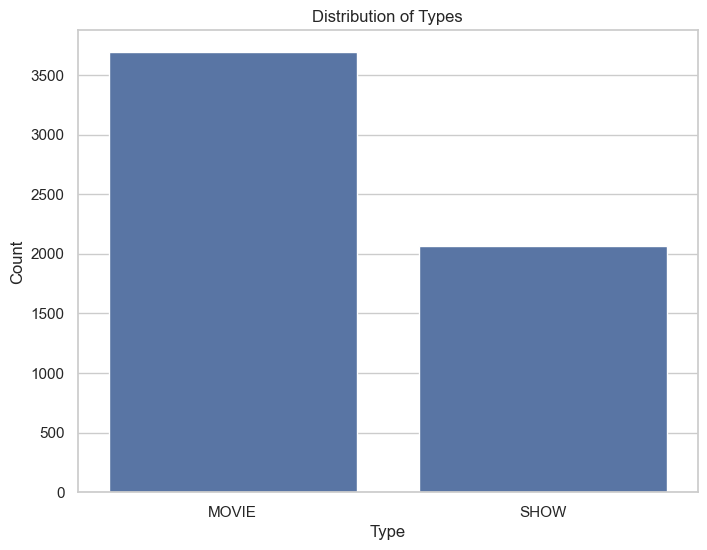

In [195]:
plt.figure(figsize=(8, 6))
sns.countplot(data=titles_clean, x='type')
plt.title('Distribution of Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

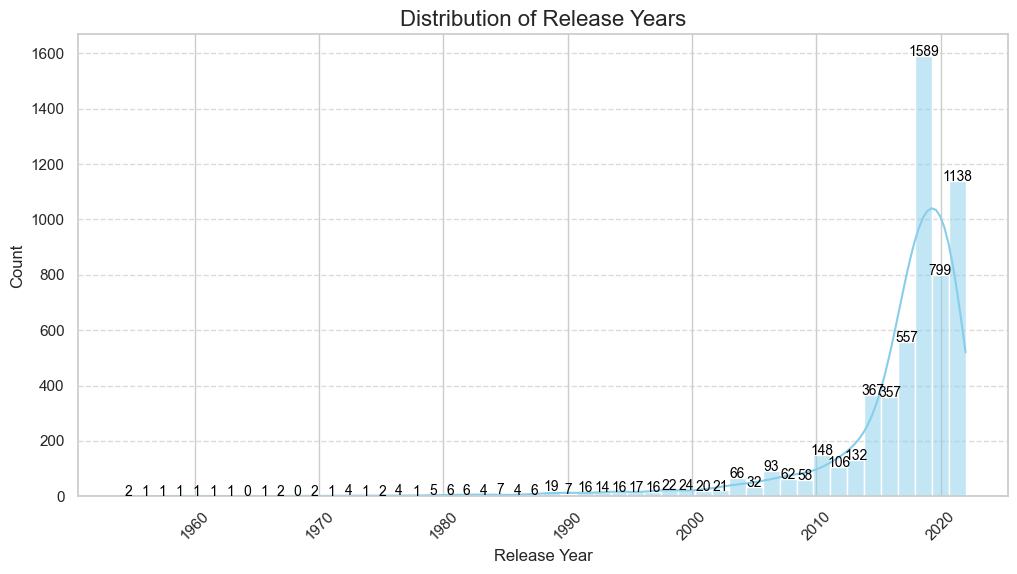

In [196]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

sns.histplot(data=titles_clean, x='release_year', bins=50, kde=True, color='skyblue')

plt.title('Distribution of Release Years', fontsize=16)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Count', fontsize=12)


plt.xticks(rotation=45)


plt.grid(axis='y', linestyle='--', alpha=0.7)

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black')

plt.show()

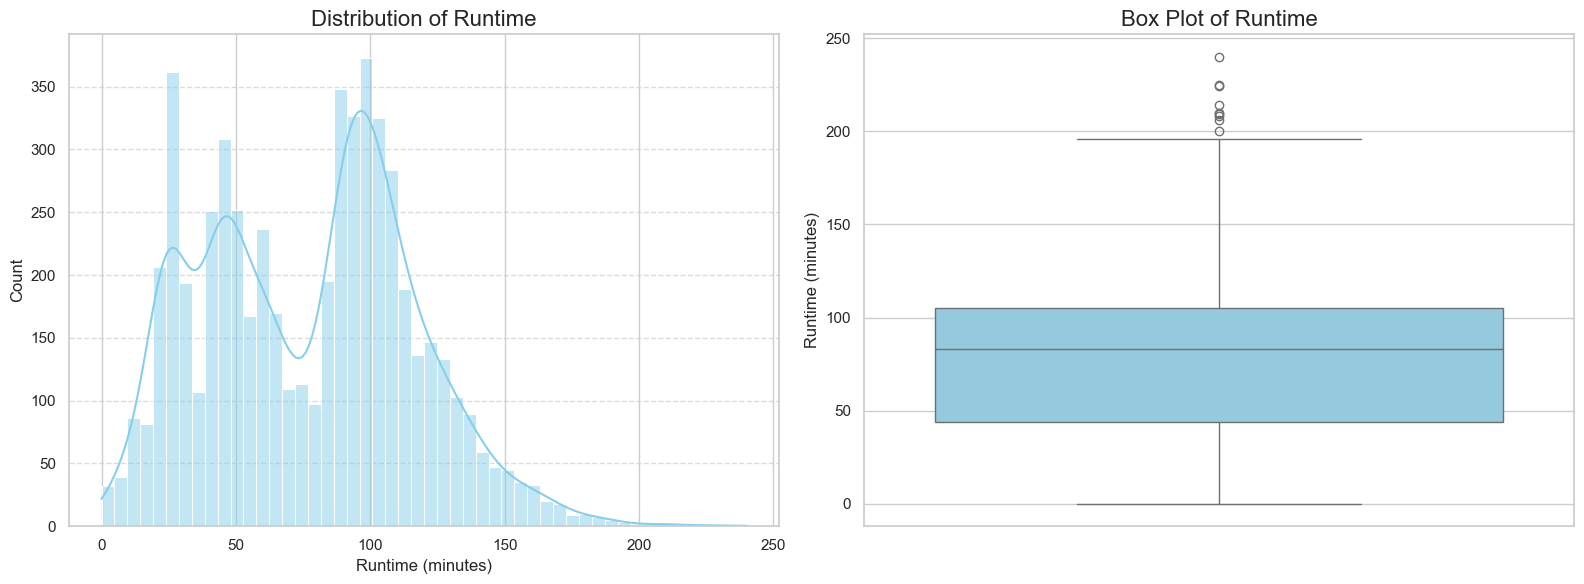

In [197]:

sns.set(style="whitegrid")

# Create a graphic with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot a distribution chart (histogram) for runtime
sns.histplot(data=titles_clean, x='runtime', bins=50, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of Runtime', fontsize=16)
axes[0].set_xlabel('Runtime (minutes)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot a box plot for runtime
sns.boxplot(data=titles_clean, y='runtime', color='skyblue', ax=axes[1])
axes[1].set_title('Box Plot of Runtime', fontsize=16)
axes[1].set_ylabel('Runtime (minutes)', fontsize=12)

plt.tight_layout()

plt.show()


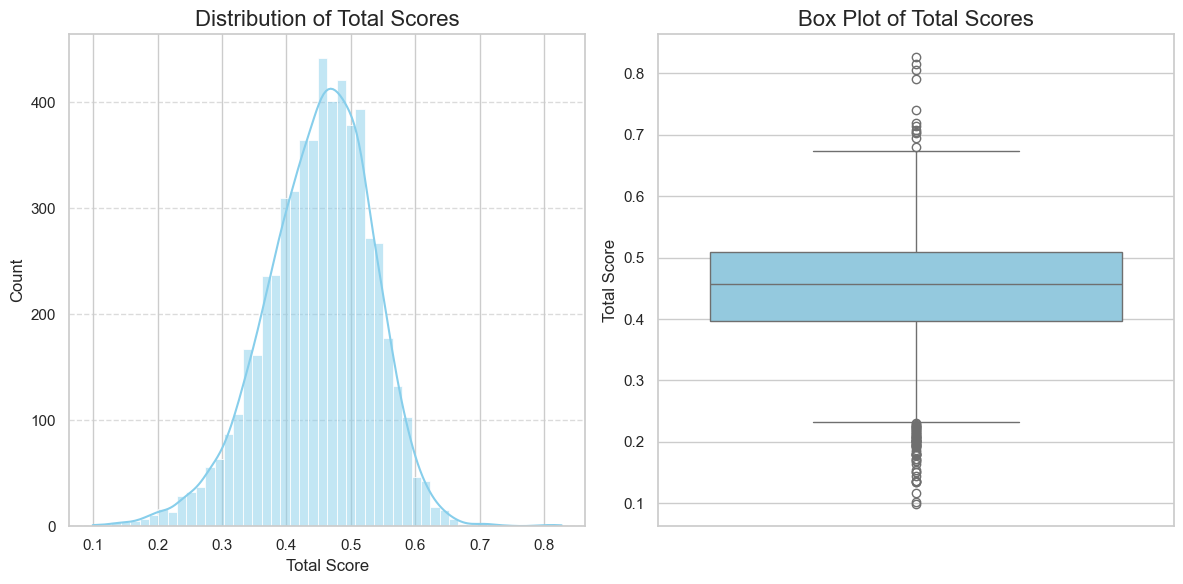

In [198]:

sns.set(style="whitegrid")

# Create a graphic with two subplots.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot a distribution chart (histogram and density estimate) for total_score
sns.histplot(data=titles_clean, x='total_score', bins=50, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of Total Scores', fontsize=16)
axes[0].set_xlabel('Total Score', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot a box plot for total_score
sns.boxplot(data=titles_clean, y='total_score', color='skyblue', ax=axes[1])
axes[1].set_title('Box Plot of Total Scores', fontsize=16)
axes[1].set_ylabel('Total Score', fontsize=12)


plt.tight_layout()

plt.show()


# Text Processing

In [199]:

import re
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
def preprocess_title(title):
    title = str(title)
    # Remove all non-alphabetic characters other than space characters
    title = re.sub(r'[^a-zA-Z\s]', '', title)
    # Convert all capital letters to lower case
    title = title.lower()
    # Tokenize each title into a list of words
    words = word_tokenize(title)
    return words


def preprocess(data):
    data = str(data)
    # Remove all non-alphabetic characters other than space characters
    alphabetic = re.sub(r'[^a-zA-Z\s]', '', data)
    # Convert all capital letters to lower case
    data = str(alphabetic).lower()
    # Tokenize the text into a list of words
    words = word_tokenize(data)
    ban_word = set(stopwords.words('english'))
    
    tokens = [lemmatizer.lemmatize(word) for word in words if word not in ban_word]
    text = ' '.join(tokens)
    
    return text

show_df['title'] = show_df['title'].apply(preprocess_title)
show_df['description'] = show_df['description'].apply(preprocess)

[nltk_data] Downloading package punkt to /Users/autumn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/autumn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/autumn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


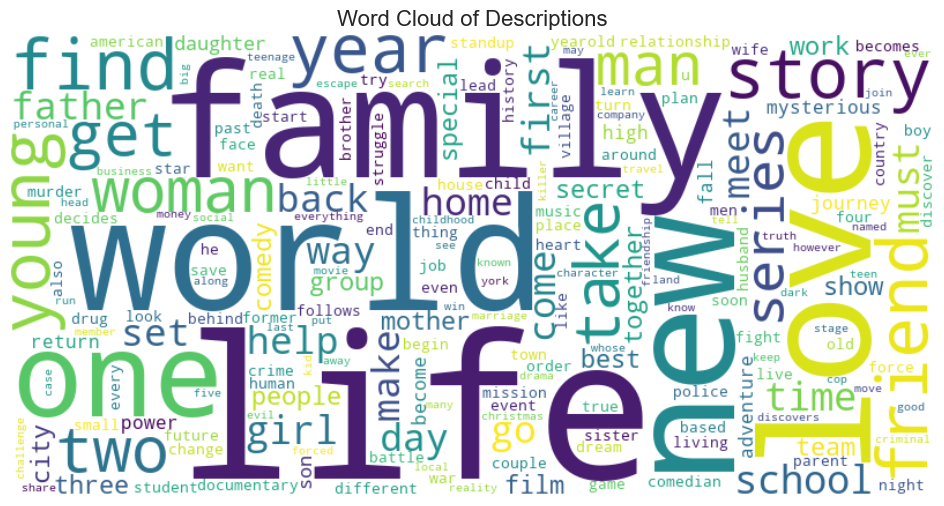

In [200]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# titles_clean = pd.read_csv('titles_clean.csv')

# Combine all description texts
all_descriptions = ' '.join(show_df['description'].astype(str))

# Split the text using spaces and calculate word frequencies
words = all_descriptions.split()
word_count = Counter(words)

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_count)

# Create the plot
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Descriptions', fontsize=16)
plt.axis('off')
plt.show()

/var/folders/0b/zrp91cdj10j9nkpv9wy7fk4m0000gn/T/ipykernel_55455/3010057250.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


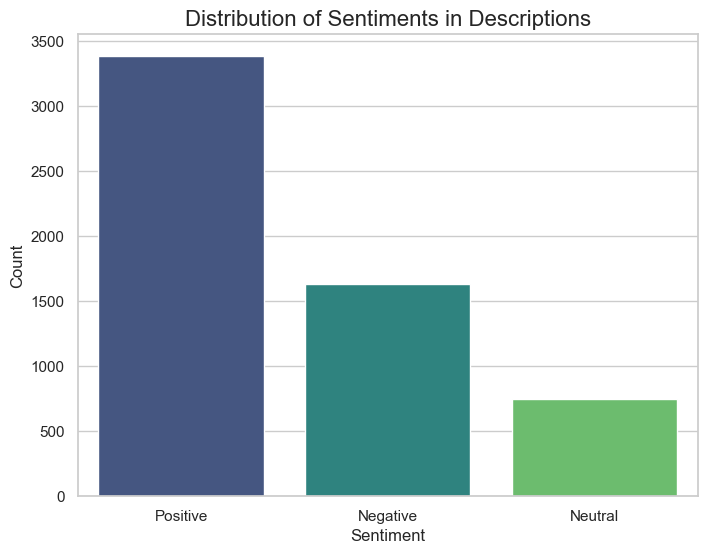

In [201]:
from textblob import TextBlob

# Create a function to obtain sentiment analysis results for the description text
def analyze_sentiment(description):
    analysis = TextBlob(description)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Apply sentiment analysis results to the description text column
titles_clean['sentiment'] = titles_clean['description'].astype(str).apply(analyze_sentiment)

# Analyze the distribution of sentiment analysis results
sentiment_counts = titles_clean['sentiment'].value_counts()

# Create a bar chart for sentiment analysis results
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Distribution of Sentiments in Descriptions', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


# Model training:

## Data combain and process
combain the cleaned credit data with cleaned title data.

In [202]:
# remove the useless features in the cleaned dataset
titles_analyise = titles_clean.drop(['imdb_score', 'imdb_votes', 'tmdb_popularity', 'tmdb_score','genres'], axis=1)

# filter the credit data to get the actors and directors data respectively
actors = credit[credit['role'] == 'ACTOR']
director = credit[credit['role'] == 'DIRECTOR']

# us id to group the actors and directors
grouped_actors = actors.groupby('id')['name'].apply(list).reset_index()
grouped_director = director.groupby('id')['name'].apply(list).reset_index()
# merge the actors and directors data from credit to the cleaned title dataset
merged_df = titles_analyise.merge(grouped_actors, on='id', how='left')
merged_df.rename(columns={'name': 'actors'}, inplace=True)
merged_df = merged_df.merge(grouped_director, on='id', how='left')
merged_df.rename(columns={'name': 'director'}, inplace=True)

# replace nah values with empty list
merged_df['actors'] = merged_df['actors'].apply(lambda x: x if isinstance(x, list) or pd.notna(x) else [])
merged_df['director'] = merged_df['director'].apply(lambda x: x if isinstance(x, list) or pd.notna(x) else [])

# replace country list to string for training
merged_df['production_countries'] = merged_df['production_countries'].apply(lambda x: ','.join([str(i) for i in x]))

# replace actors and director list to string for training
merged_df['actors'] = merged_df['actors'].apply(lambda x: ','.join([str(i) for i in x]))
merged_df['director'] = merged_df['director'].apply(lambda x: ','.join([str(i) for i in x]))

merged_df

,id,title,type,description,release_year,runtime,production_countries,imdb_score_normalized,imdb_votes_normalized,tmdb_popularity_normalized,...,genre_reality,genre_romance,genre_scifi,genre_sport,genre_thriller,genre_war,genre_western,sentiment,actors,director
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works as a night-time taxi driver in New York City where the perceived decadence and sleaze feed his urge for violent action.,1976,114,US,0.827160,0.352440,0.017990,...,0,0,0,0,0,0,0,Negative,"Robert De Niro,Jodie Foster,Albert Brooks,Harvey Keitel,Cybill Shepherd,Peter Boyle,Leonard Harris,Diahnne Abbott,Gino Ardito,Martin Scorsese,Murray Moston,Richard Higgs,Bill Minkin,Bob Maroff,Victor Argo,Joe Spinell,Robinson Frank Adu,Brenda Dickson,Norman Matlock,Harry Northup,Harlan Cary Poe,Steven Prince,Peter Savage,Nicholas Shields,Ralph S. Singleton,Annie Gagen,Carson Grant,Mary-Pat Green,Debbi Morgan,Don Stroud,Copper Cunningham,Garth Avery,Nat Grant,Billie Perkins,Catherine Scorsese,Charles Scorsese",Martin Scorsese
1,tm154986,Deliverance,MOVIE,"Intent on seeing the Cahulawassee River before it's turned into one huge lake, outdoor fanatic Lewis Medlock takes his friends on a river-rafting trip they'll never forget into the dangerous American back-country.",1972,109,US,0.765432,0.046930,0.004378,...,0,0,0,0,1,0,0,Negative,"Jon Voight,Burt Reynolds,Ned Beatty,Ronny Cox,Ed Ramey,Billy Redden,Seamon Glass,Randall Deal,Bill McKinney,Herbert 'Cowboy' Coward,Lewis Crone,Ken Keener,Johnny Popwell,John Fowler,Kathy Rickman,Louise Coldren,Pete Ware,James Dickey,Macon McCalman,Hoyt Pollard,Belinda Beatty,Charley Boorman",John Boorman
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recruits his Knights of the Round Table, including Sir Bedevere the Wise, Sir Lancelot the Brave, Sir Robin the Not-Quite-So-Brave-As-Sir-Lancelot and Sir Galahad the Pure. On the way, Arthur battles the Black Knight who, despite having had all his limbs chopped off, insists he can still fight. They reach Camelot, but Arthur decides not to enter, as ""it is a silly place"".",1975,91,GB,0.827160,0.232968,0.006775,...,0,0,0,0,0,0,0,Positive,"Graham Chapman,John Cleese,Eric Idle,Terry Gilliam,Terry Jones,Michael Palin,Connie Booth,Carol Cleveland,Neil Innes,Bee Duffell,John Young,Rita Davies,Avril Stewart,Sally Kinghorn,Mark Zycon,Elspeth Cameron,Mitsuko Forstater,Sandy Johnson,Sandy Rose,Romilly Squire,Joni Flynn,Alison Walker,Loraine Ward,Anna Lanski,Sally Coombe,Vivienne MacDonald,Yvonne Dick,Daphne Darling,Fiona Gordon,Judy Lamb,Tracy Sneddon,Joyce Pollner,Mary Allen,Gloria Graham,Sylvia Taylor,Julian Doyle,Margarita Doyle,Zack Matalon,Scott Mike,William Palin,Terry Jones,Tom Raeburn,Brian Ross,Roy Forge Smith,John Thornton...","Terry Jones,Terry Gilliam"
3,tm120801,The Dirty Dozen,MOVIE,"12 American military prisoners in World War II are ordered to infiltrate a well-guarded enemy château and kill the Nazi officers vacationing there. The soldiers, most of whom are facing death sentences for a variety of violent crimes, agree to the mission and the possible commuting of their sentences.",1967,150,US,0.765432,0.031670,0.008946,...,0,0,0,0,0,1,0,Negative,"Lee Marvin,Ernest Borgnine,Charles Bronson,Jim Brown,John Cassavetes,Richard Jaeckel,George Kennedy,Trini López,Ralph Meeker,Robert Ryan,Telly Savalas,Donald Sutherland,Clint Walker,Robert Webber,Tom Busby,Ben Carruthers,Stuart Cooper,Robert Phillips,Colin Maitland,Al Mancini,George Roubicek,Thick Wilson,Dora Reisser,Michael Anthony,Leo Britt,Alan Chuntz,Gary Files,Judith Furse,Hal Galili,Romo Gorrara,Willoughby Gray,Gerard Heinz,John G. Heller,George Hilsdon,John Hollis,Alf Joint,Juba Kennerley,Hildegard Knef,Ann Lancaster,Richard Marner,Dick Miller,Lionel Murton,Suzanne Owens-Duval,Mike ...",Robert Aldrich
4,ts22164,Monty Python's Flying Circus,SHOW,"A British sketch comedy series with the shows being composed of surreality, risqué or innuendo-lade

In [203]:
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split

# split the dataset into train and test dataset
train, test = train_test_split(merged_df, test_size=0.2)  # 80% training and 20% test

train_data = TabularDataset(train.drop(columns=['imdb_score_normalized','imdb_votes_normalized','tmdb_popularity_normalized','tmdb_score_normalized']))



# Feature selection
Positive output means while the feature increase, the score while increase. Negative it the inverse of positive.

In [204]:
from scipy.stats import pearsonr
# calculate Pearson's correlation
correlations = {}
for column in train.drop(columns=['total_score']):
    if train[column].dtype != 'object':  
        correlation, _ = pearsonr(train[column], train['total_score'])
        correlations[column] = correlation

# Rank the features by their correlation with total_score
sorted_features = sorted(correlations.keys(), key=lambda x: abs(correlations[x]), reverse=True)

# Print the feature and their correlation with total_score
for feature in sorted_features:
    print(f"{feature}: {correlations[feature]}")


imdb_score_normalized: 0.9246775407901637
tmdb_score_normalized: 0.8110421483630665
imdb_votes_normalized: 0.26843858942201576
runtime: -0.20635751457471246
genre_documentation: 0.14001459812688355
genre_history: 0.11460489971607396
tmdb_popularity_normalized: 0.10552051693641123
genre_animation: 0.10170383903106983
genre_drama: 0.10044210814318012
genre_horror: -0.09715430535928879
release_year: -0.09084923189769889
genre_comedy: -0.08695062381834415
genre_war: 0.06999259537914729
genre_scifi: 0.060728884134097175
genre_thriller: -0.05743540927228312
genre_romance: -0.05150670970990015
genre_crime: 0.04820982600081915
genre_fantasy: 0.0421127607523524
genre_action: -0.02700258925495866
genre_european: -0.022936064392031212
genre_sport: 0.021631125527089054
genre_music: 0.018716288639725673
genre_reality: 0.008076786406701468
genre_family: 0.0028541756048187875
genre_western: -0.0015024681079542218


# Train model

# Decision Tree Model

In [205]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from scipy.sparse import hstack, csr_matrix
from sklearn.linear_model import Ridge

# Deal with missing values in 'description' and 'title' columns
merged_df['description'].fillna('', inplace=True)
merged_df['title'].fillna('', inplace=True)

X_description = merged_df['description']
X_title = merged_df['title']
y = merged_df['total_score']

# Create a text feature extractor (BoW)
vectorizer = CountVectorizer(stop_words='english')
X_description_features = vectorizer.fit_transform(X_description)
X_title_features = vectorizer.transform(X_title)

# Score prediction model
X_numeric = merged_df.drop(columns=['title', 'type', 'description','total_score','imdb_score_normalized', 'tmdb_popularity_normalized', 'imdb_votes_normalized', 'tmdb_score_normalized', 'id']) 

numeric_columns = X_numeric.select_dtypes(include=['int64', 'float64'])
X_numeric_sparse = csr_matrix(numeric_columns.values)

# Convert text features to dense matrices
X_description_features_dense = X_description_features.toarray()
X_title_features_dense = X_title_features.toarray()

# Combine text features and numerical features
X_combined = hstack([X_description_features, X_title_features, X_numeric_sparse])
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)



# Autogluon model

In [206]:
# use the autogluon to train the model, the predict label is total_score.
import lightgbm

id, lablel = 'id', 'total_score'
predictor = TabularPredictor(label=lablel).fit(train_data.drop(columns=[id]))


No path specified. Models will be saved in: "AutogluonModels/ag-20231005_070213/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231005_070213/"
AutoGluon Version:  0.8.2
Python Version:     3.8.18
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 23.0.0: Fri Sep 15 14:41:43 PDT 2023; root:xnu-10002.1.13~1/RELEASE_ARM64_T6000
Disk Space Avail:   16.73 GB / 494.38 GB (3.4%)
Train Data Rows:    4608
Train Data Columns: 28
Label Column: total_score
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (0.8272316025486952, 0.09907501525663762, 0.44963, 0.08371)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Usi

# Model evaluation

## data Valiadation


Decision tree

In [207]:
# K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# evaluation metrics
mse_scores = []
rmse_scores = []
mae_scores = []
r2_scores = []


# Use K-fold cross-validation
for train_index, test_index in kf.split(X_combined):
    X_train, X_test = X_combined[train_index], X_combined[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create a Deci sion Tree Regressor model
    model = DecisionTreeRegressor()
    
    # Use Ridge regression with L2 regularization
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate performance metrics and add them to the lists
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

# Print the average performance metrics
print("Average MSE:", np.mean(mse_scores))
print("Average RMSE:", np.mean(rmse_scores))
print("Average MAE:", np.mean(mae_scores))
print("Average R^2:", np.mean(r2_scores))

Average MSE: 0.009288819159277982
Average RMSE: 0.09634658205784326
Average MAE: 0.07349104169097277
Average R^2: -0.3297141693045281


Autogluon

In [208]:
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# define the evaluation metrics
mse_scores = []
rmse_scores = []
mae_scores = []

# define the cross validation method
m = 5 
kf = KFold(n_splits=m, shuffle=True, random_state=42)

label = 'total_score'
id = 'id'

# split the dataset into train and test dataset
for train_index, test_index in kf.split(merged_df):
    train, test = merged_df.iloc[train_index], merged_df.iloc[test_index]
    
    train_data = TabularDataset(train.drop(columns=['imdb_score_normalized','imdb_votes_normalized','tmdb_popularity_normalized','tmdb_score_normalized']))
    predictor = TabularPredictor(label=label).fit(train_data.drop(columns=[id]))
    
    test_data = test.drop(columns=[label,'imdb_score_normalized','imdb_votes_normalized','tmdb_popularity_normalized','tmdb_score_normalized'])
    y_true = test[label].values
    y_pred = predictor.predict(test_data)

    # calculate the evaluation metrics
    mse_scores.append(mean_squared_error(y_true, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae_scores.append(mean_absolute_error(y_true, y_pred))

# print the evaluation metrics
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")


No path specified. Models will be saved in: "AutogluonModels/ag-20231005_070306/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231005_070306/"
AutoGluon Version:  0.8.2
Python Version:     3.8.18
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 23.0.0: Fri Sep 15 14:41:43 PDT 2023; root:xnu-10002.1.13~1/RELEASE_ARM64_T6000
Disk Space Avail:   16.51 GB / 494.38 GB (3.3%)
Train Data Rows:    4608
Train Data Columns: 28
Label Column: total_score
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (0.8272316025486952, 0.10244006524277638, 0.45101, 0.08321)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Usi

Average MSE: 0.004674351979179118
Average RMSE: 0.06836620357882511
Average MAE: 0.05234184948947771


# Testing

Atuogluon

In [209]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

import numpy as np

# Predict on test data
y_pred = predictor.predict(test.drop(columns=['imdb_score_normalized', 'imdb_votes_normalized', 'tmdb_popularity_normalized', 'tmdb_score_normalized']))
y_true = test['total_score'].values

# Calculate evaluation metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}")


MSE: 0.004554159195036173
RMSE: 0.06748451077866811
MAE: 0.051512835445188955
R^2: 0.32099688813440064


# Data visualization

Dicision tree model graphs

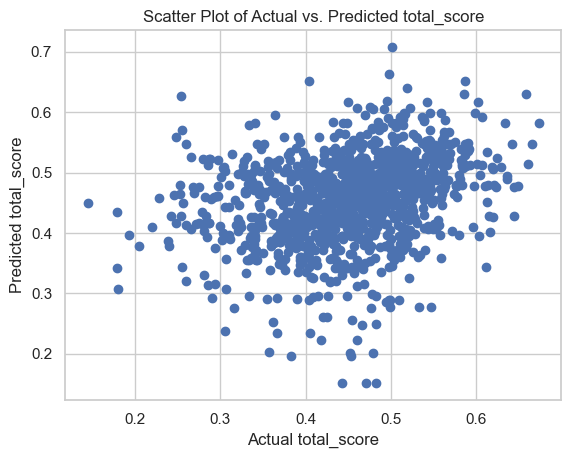

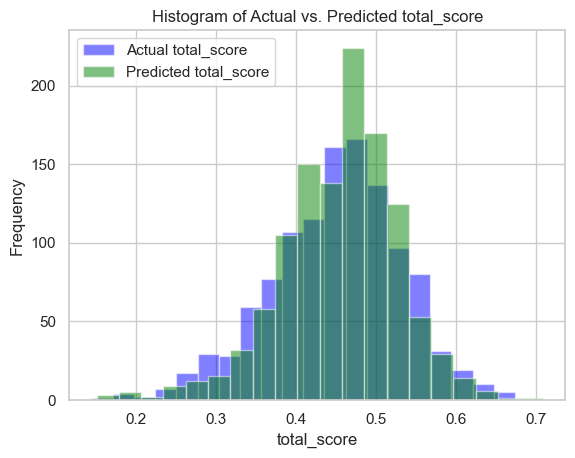

/var/folders/0b/zrp91cdj10j9nkpv9wy7fk4m0000gn/T/ipykernel_55455/3389228023.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, label="Actual total_score", shade=True)
/var/folders/0b/zrp91cdj10j9nkpv9wy7fk4m0000gn/T/ipykernel_55455/3389228023.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(final_y_pred, label="Predicted total_score", shade=True)


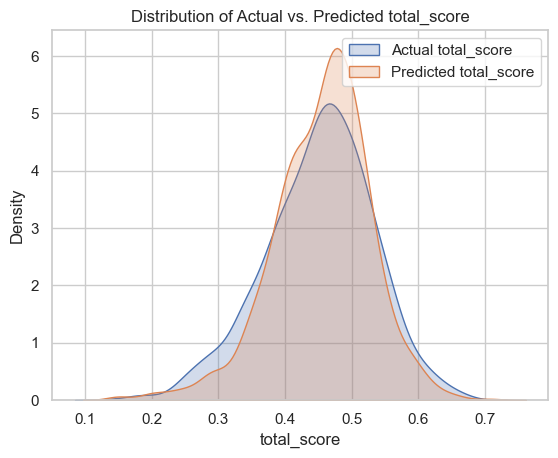

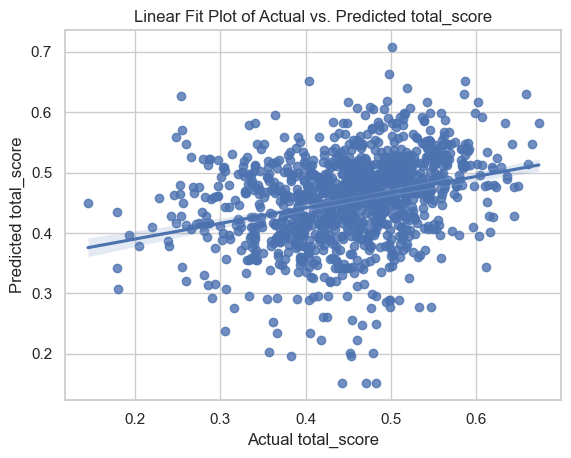

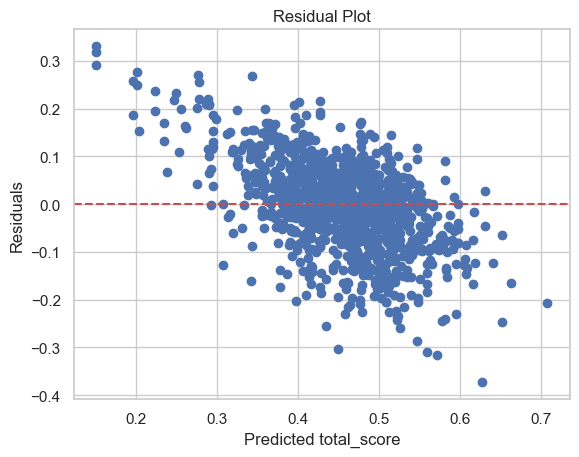

In [210]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the model's predictions in the final iteration of K-fold cross-validation
final_y_pred = model.predict(X_test)

# Scatter plot
plt.scatter(y_test, final_y_pred)
plt.xlabel("Actual total_score")
plt.ylabel("Predicted total_score")
plt.title("Scatter Plot of Actual vs. Predicted total_score")
plt.show()

# Histogram
plt.hist(y_test, bins=20, alpha=0.5, label='Actual total_score', color='blue')
plt.hist(final_y_pred, bins=20, alpha=0.5, label='Predicted total_score', color='green')
plt.xlabel("total_score")
plt.ylabel("Frequency")
plt.legend()
plt.title("Histogram of Actual vs. Predicted total_score")
plt.show()

# Distribution Plot
sns.kdeplot(y_test, label="Actual total_score", shade=True)
sns.kdeplot(final_y_pred, label="Predicted total_score", shade=True)
plt.title('Distribution of Actual vs. Predicted total_score')
plt.legend()
plt.show()


# Linear fit plot
sns.regplot(x=y_test, y=final_y_pred)
plt.xlabel("Actual total_score")
plt.ylabel("Predicted total_score")
plt.title("Linear Fit Plot of Actual vs. Predicted total_score")
plt.show()

# Residual plot
residuals = y_test - final_y_pred
plt.scatter(final_y_pred, residuals)
plt.xlabel("Predicted total_score")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

Autogluon model graphs

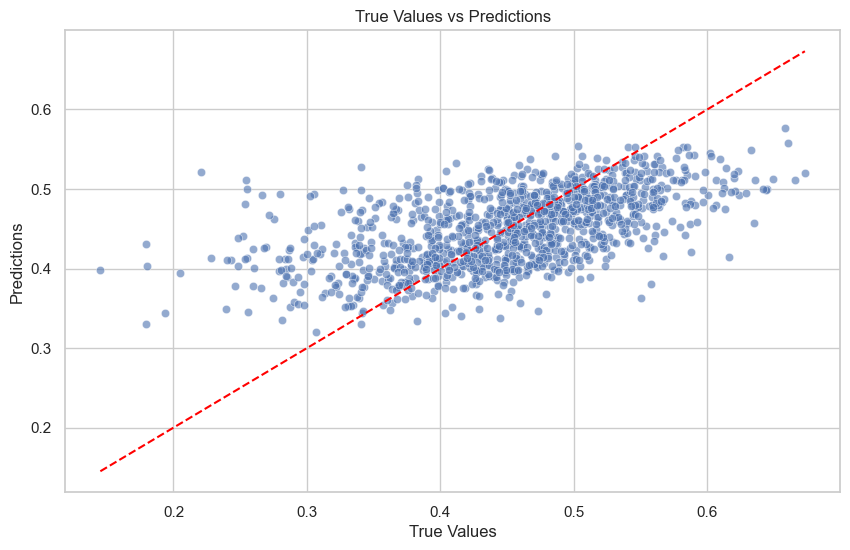

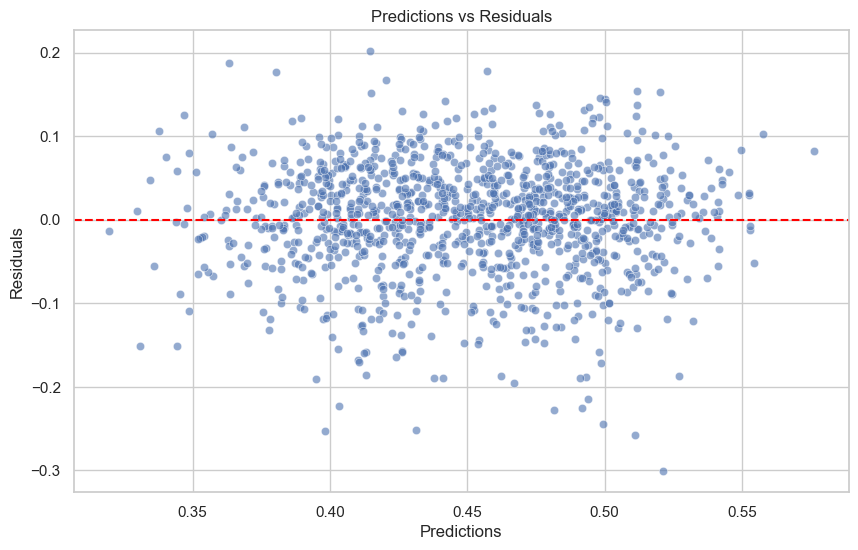

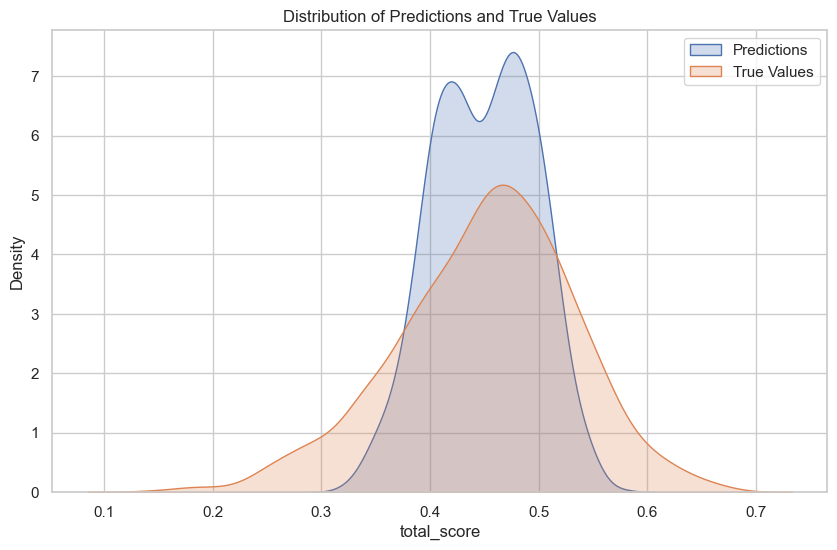

These features in provided data are not utilized by the predictor and will be ignored: ['id', 'imdb_score_normalized', 'imdb_votes_normalized', 'tmdb_popularity_normalized', 'tmdb_score_normalized']
Computing feature importance via permutation shuffling for 28 features using 1152 rows with 5 shuffle sets...
	53.97s	= Expected runtime (10.79s per shuffle set)
	31.95s	= Actual runtime (Completed 5 of 5 shuffle sets)


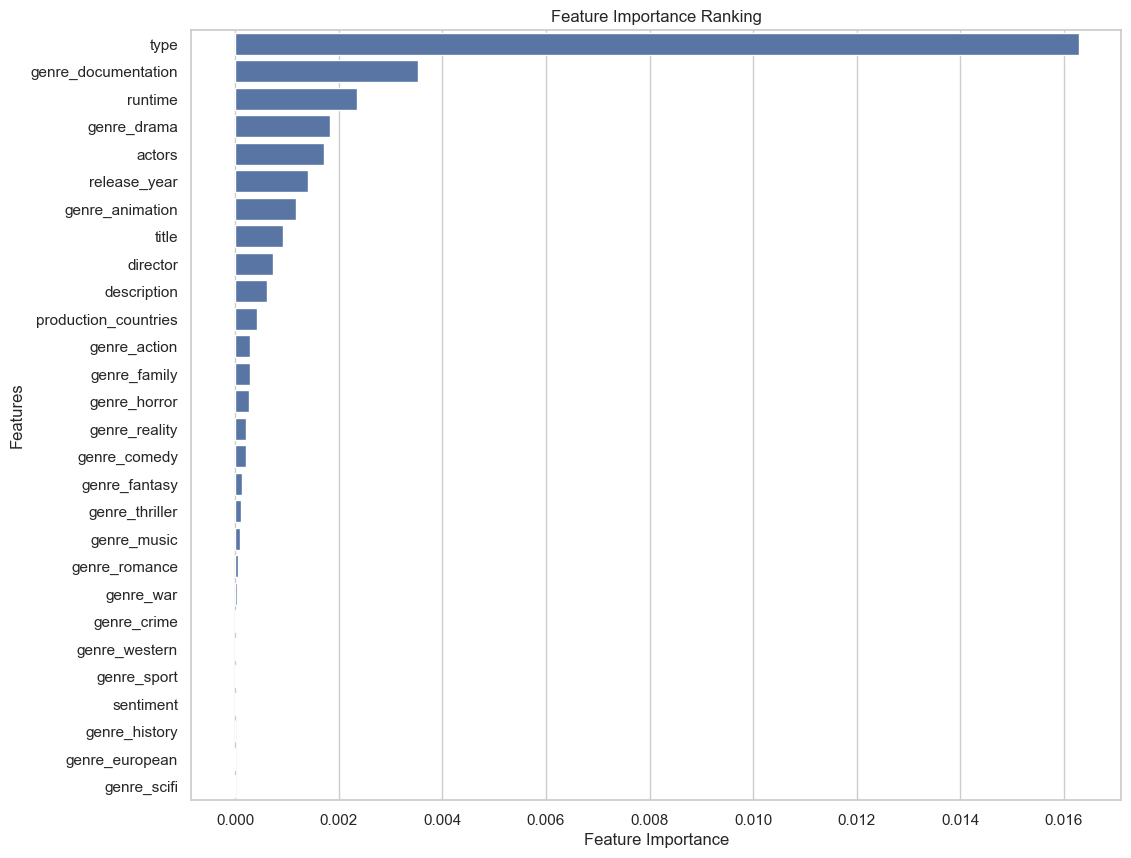

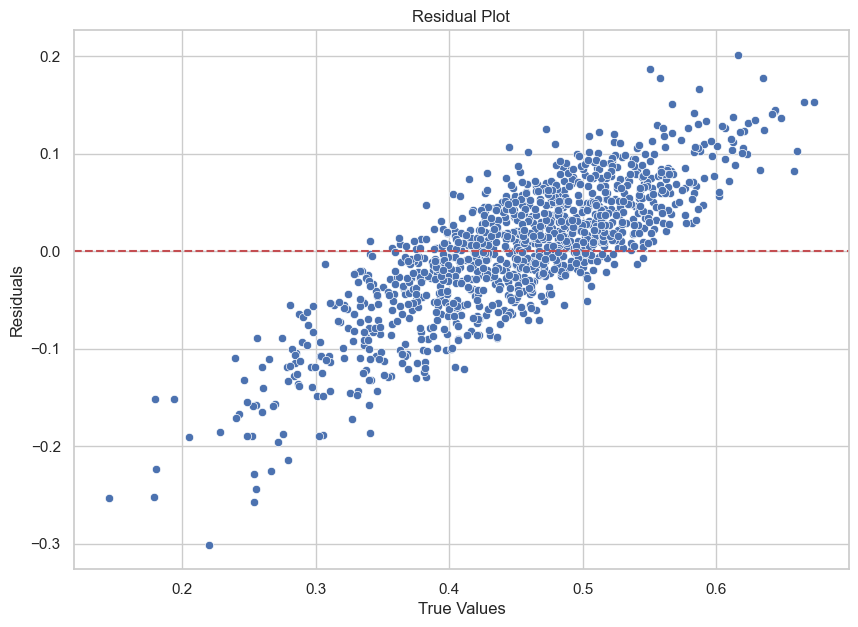

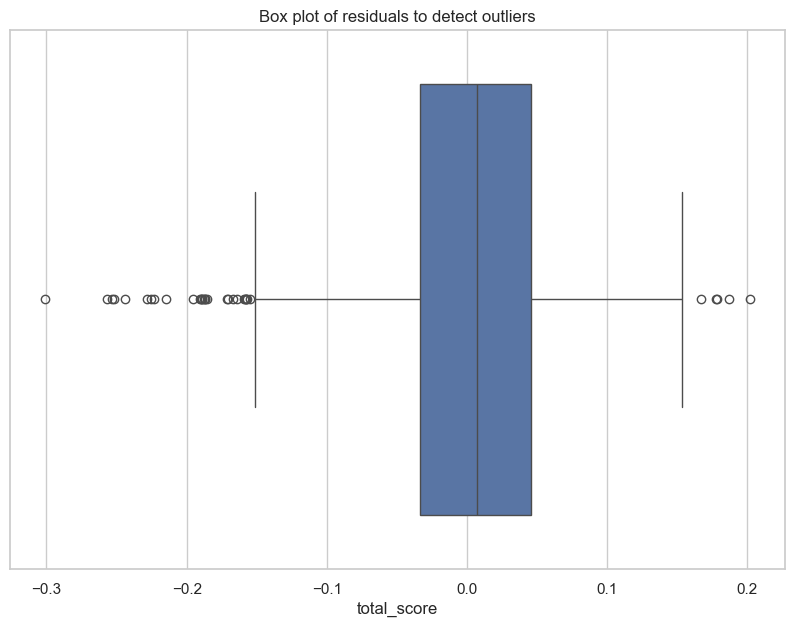

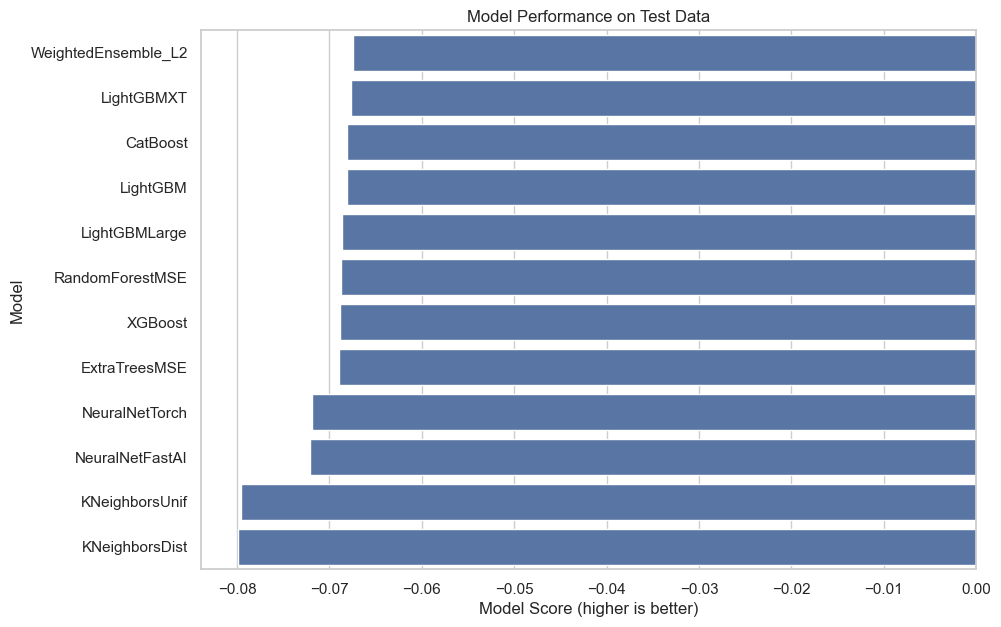

In [211]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
plt.show()

# Residual Plot
residuals = y_true - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Predictions vs Residuals')
plt.show()

# Distribution Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(y_pred, label="Predictions", fill=True)  
sns.kdeplot(y_true, label="True Values", fill=True) 
plt.title('Distribution of Predictions and True Values')
plt.legend()
plt.show()

# Feature Importance
feature_importance = predictor.feature_importance(data=test)
plt.figure(figsize=(12, 10))
sns.barplot(x=feature_importance['importance'], y=feature_importance.index)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Ranking')
plt.show()

predictions = predictor.predict(test)
residuals = test[lablel] - predictions
plt.figure(figsize=(10, 7))
sns.scatterplot(x=test[lablel], y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Box Plot of residuals
plt.figure(figsize=(10, 7))
sns.boxplot(x=residuals)
plt.title('Box plot of residuals to detect outliers')
plt.show()

# Model performance on test data
leaderboard = predictor.leaderboard(test, silent=True)
plt.figure(figsize=(10, 7))
sns.barplot(x='score_test', y='model', data=leaderboard)  
plt.xlabel('Model Score (higher is better)')
plt.ylabel('Model')
plt.title('Model Performance on Test Data')
plt.show()# Description and Title Decision Tree Model


# predict average score for each genre

In [212]:
# Features and target
genres = ['genre_action', 'genre_animation', 'genre_comedy', 'genre_crime', 'genre_documentation', 'genre_drama', 'genre_european', 'genre_family', 'genre_fantasy', 'genre_history', 'genre_horror', 'genre_music', 'genre_reality', 'genre_romance', 'genre_scifi', 'genre_sport', 'genre_thriller', 'genre_war', 'genre_western']
score = 'imdb_score_normalized'

# Create an empty DataFrame to store prediction results
predicted_scores = pd.DataFrame(columns=['Genre', 'Predicted_Score'])

# Create Decision Tree Regression models and predict the average scores for each genre
for genre in genres:
    genre_data = merged_df[merged_df[genre] == 1]
    
    if not genre_data.empty:
        X = genre_data[genres]
        y = genre_data[score]
    
        model = DecisionTreeRegressor()
        model.fit(X, y)
    
        # Make predictions
        predicted_score = model.predict(X)
    
        # Add the prediction results to the DataFrame
        predicted_scores = pd.concat([predicted_scores, pd.DataFrame({'Genre': [genre], 'Predicted_Score': [predicted_score.mean()]})], ignore_index=True)

# Print the prediction results
print(predicted_scores.sort_values(by='Predicted_Score', ascending=False))

                  Genre  Predicted_Score
9         genre_history         0.694906
17            genre_war         0.685410
4   genre_documentation         0.675337
1       genre_animation         0.641433
15          genre_sport         0.636093
3           genre_crime         0.635712
5           genre_drama         0.632897
14          genre_scifi         0.625465
8         genre_fantasy         0.624320
6        genre_european         0.619698
11          genre_music         0.619324
18        genre_western         0.614650
0          genre_action         0.608600
12        genre_reality         0.607810
2          genre_comedy         0.605034
13        genre_romance         0.602347
16       genre_thriller         0.601246
7          genre_family         0.597584
10         genre_horror         0.557356
